In [1]:
!mv /Users/camerondavidson-pilon/Downloads/*.dump.gz ..
!gzip -f -d ../*.dump.gz
!rm ../morbidostat.db
!sqlite3 ../morbidostat.db < ../od_readings_raw.dump


(B(B(B(B

In [17]:
import pandas as pd
import sqlite3
con = sqlite3.connect("../morbidostat.db")
experiment = "Trial-10-3f9b884da633474f9e9dd641a57d4cb7-take2"
unit = 1
df = pd.read_sql_query(f'SELECT * from od_readings_raw WHERE experiment="{experiment}" and morbidostat_unit="{unit}"', con)


In [18]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index("timestamp")


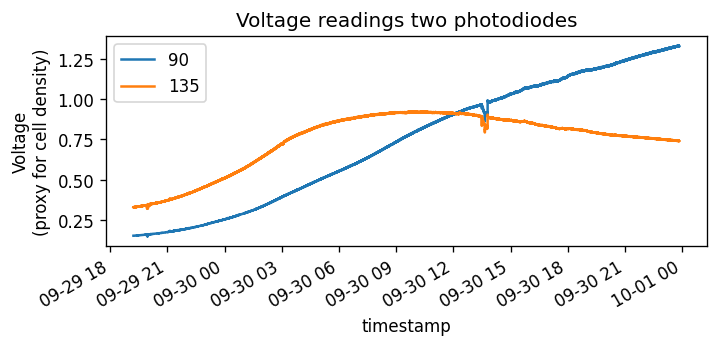

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6.0, 3.0]
plt.rcParams['figure.dpi'] = 120
plt.figure()

for _, g in df.groupby("angle")['od_reading_v']:
    g.plot(label=_)

plt.legend()
plt.title("Voltage readings two photodiodes")
plt.ylabel("Voltage\n(proxy for cell density)")
plt.tight_layout()

In [20]:
df.head()

,morbidostat_unit,od_reading_v,experiment,angle
timestamp,,,,
2020-09-29 19:13:00.505000+00:00,1,0.327635,Trial-10-3f9b884da633474f9e9dd641a57d4cb7-take2,135
2020-09-29 19:13:00.567000+00:00,1,0.150192,Trial-10-3f9b884da633474f9e9dd641a57d4cb7-take2,90
2020-09-29 19:13:05.520000+00:00,1,0.327698,Trial-10-3f9b884da633474f9e9dd641a57d4cb7-take2,135
2020-09-29 19:13:05.561000+00:00,1,0.150130,Trial-10-3f9b884da633474f9e9dd641a57d4cb7-take2,90
2020-09-29 19:13:10.510000+00:00,1,0.327948,Trial-10-3f9b884da633474f9e9dd641a57d4cb7-take2,135


In [21]:
from morbidostat.utils.streaming_calculations import ExtendedKalmanFilter

<AxesSubplot:xlabel='timestamp'>

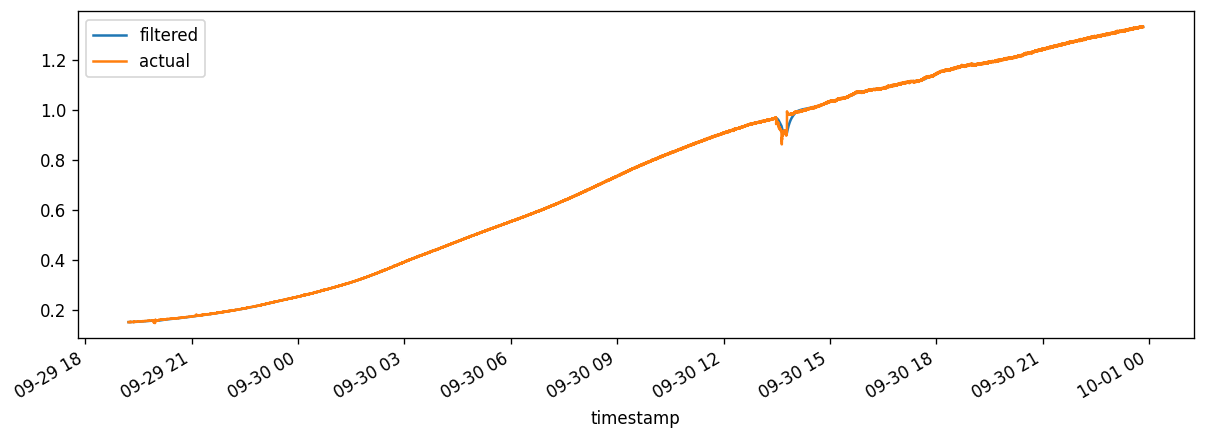

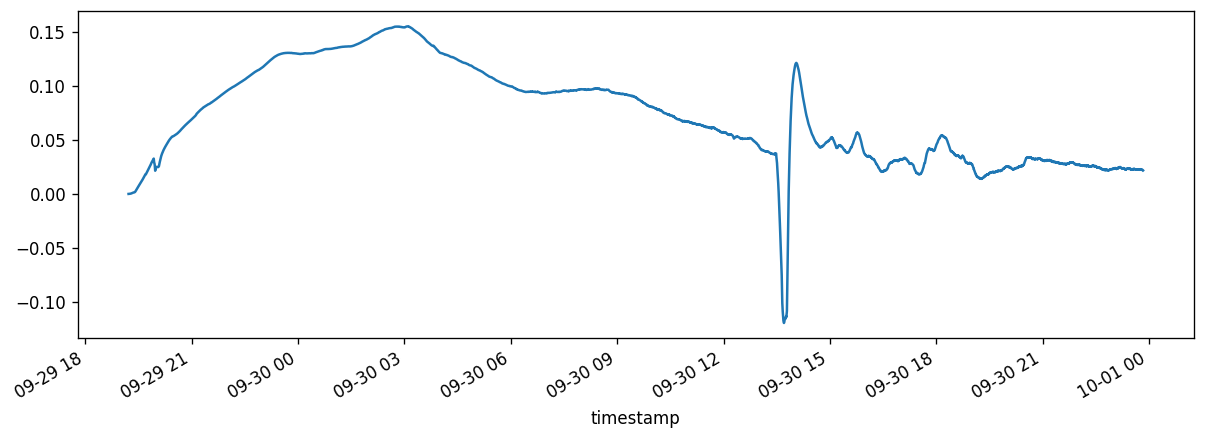

In [53]:
initial_state = np.array([0.150192, 1.000])
d = initial_state.shape[0]

# empirically picked constants
initial_covariance = np.block([
    [1e-4 * np.ones((d-1, d-1)), 1e-7 * np.ones((d-1, 1))], [1e-7 * np.ones((1, d-1)), 1e-8]
])

OD_process_covariance = 1e-10 * np.ones((d-1, d-1))
OD_process_covariance[0, 0] = 1e-7
rate_process_variance = (
    5e-12
)  # think of this as a weighting between how much do I trust the model (lower value => rate_t == rate_{t-1}) vs how much do I trust the observations
process_noise_covariance = np.block(
    [[OD_process_covariance, 1e-12 * np.ones((d - 1, 1))], [1e-12 * np.ones((1, d - 1)), rate_process_variance]]
)

observation_noise_covariance = 1e-3 * np.eye(d - 1) # this is a function of the ADS resolution at a gain

ekf = ExtendedKalmanFilter(
    initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
)


results = []

for x in df.loc[df['angle'] == 90, 'od_reading_v']:
        ekf.update(np.array([x]))
        results.append(ekf.state_)

results_90 = pd.DataFrame(results, columns=['90', 'rate'], index=df.loc[df['angle'] == 90, 'od_reading_v'].index)


plt.figure(figsize=(12, 4))

results_90["90"].plot(label="filtered")
df.loc[df['angle'] == 90, 'od_reading_v'].plot(label="actual")
plt.legend()

plt.figure(figsize=(12, 4))

(np.log(results_90["rate"]) * 60 * 60 * 0.2).plot()


<AxesSubplot:xlabel='timestamp'>

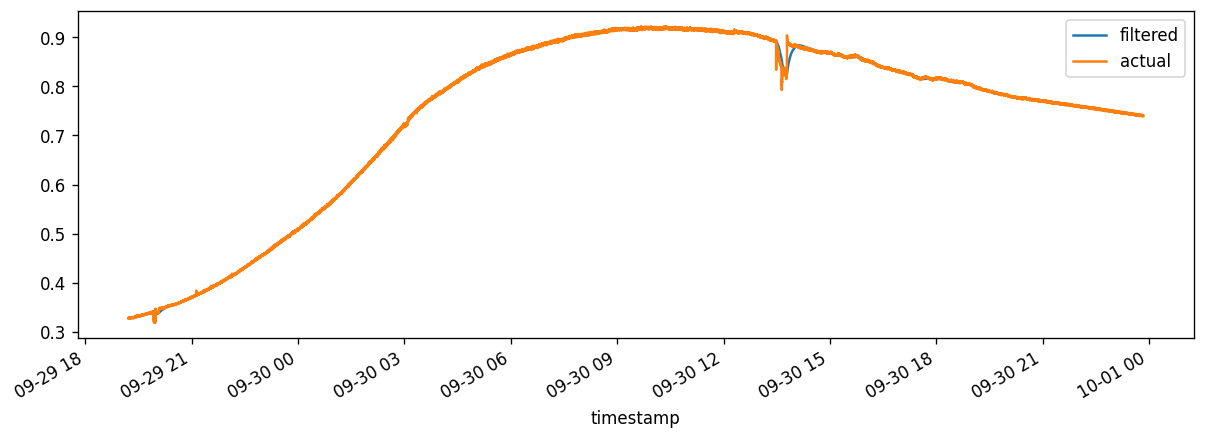

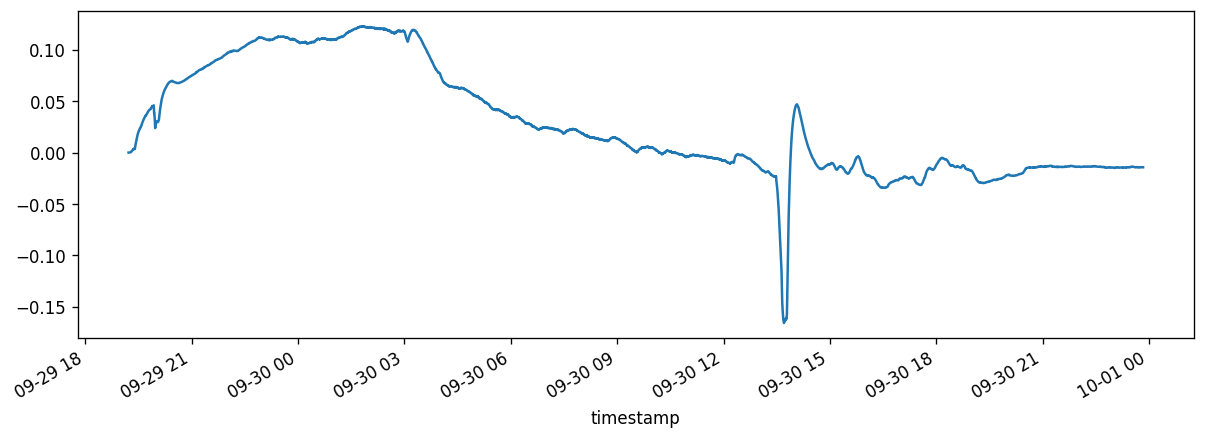

In [54]:
initial_state = np.array([0.327635, 1.000])
d = initial_state.shape[0]

# empirically picked constants
initial_covariance = np.block([
    [1e-4 * np.ones((d-1, d-1)), 1e-7 * np.ones((d-1, 1))], [1e-7 * np.ones((1, d-1)), 1e-8]
])

OD_process_covariance = 1e-10 * np.ones((d-1, d-1))
OD_process_covariance[0, 0] = 1e-7
rate_process_variance = (
    5e-12
)  # think of this as a weighting between how much do I trust the model (lower value => rate_t == rate_{t-1}) vs how much do I trust the observations
process_noise_covariance = np.block(
    [[OD_process_covariance, 1e-12 * np.ones((d - 1, 1))], [1e-12 * np.ones((1, d - 1)), rate_process_variance]]
)

observation_noise_covariance = 1e-3 * np.eye(d - 1) # this is a function of the ADS resolution at a gain

ekf = ExtendedKalmanFilter(
    initial_state, initial_covariance, process_noise_covariance, observation_noise_covariance,
)


results = []

for x in df.loc[df['angle'] == 135, 'od_reading_v']:
        ekf.update(np.array([x]))
        results.append(ekf.state_)

results_135 = pd.DataFrame(results, columns=['135', 'rate'], index=df.loc[df['angle'] == 135, 'od_reading_v'].index)


plt.figure(figsize=(12, 4))

results_135["135"].plot(label="filtered")
df.loc[df['angle'] == 135, 'od_reading_v'].plot(label="actual")
plt.legend()

plt.figure(figsize=(12, 4))

(np.log(results_135["rate"]) * 60 * 60 * 0.2).plot()

<AxesSubplot:xlabel='timestamp'>

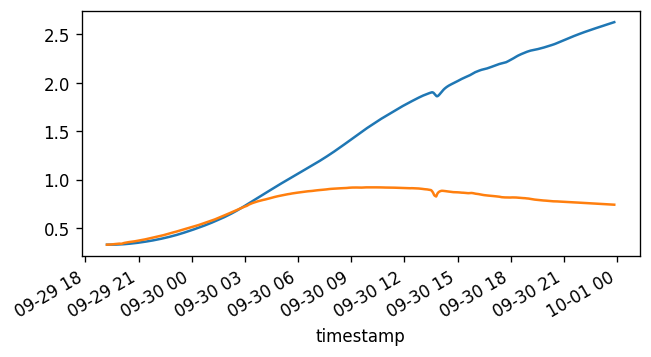

In [55]:
(results_90['rate'].cumprod() * df.loc[df['angle'] == 135, 'od_reading_v'].iloc[0]).plot()
results_135["135"].plot(label="filtered")


In [56]:
cf = results_90['rate'].cumprod() * df.loc[df['angle'] == 135, 'od_reading_v'].iloc[0]
obs = results_135["135"]

In [57]:
def sat(x):
    assert 2.6 >= x >= 0.33
    ts = (cf - x).abs().idxmin()
    return obs.iloc[obs.index.get_loc(ts, method='nearest')]

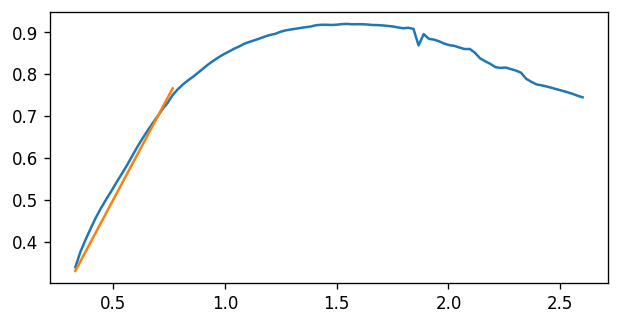

In [62]:
x = np.linspace(0.33, 2.6, 100)
y = []

for _ in x:
    y.append(sat(_))

plt.plot(x, y)
plt.plot(x[:20], x[:20])

In [66]:
x[np.argmax(y)]

1.5452525252525253

In [67]:
min(x)

0.33

In [68]:
def lq(x, params):
    a, m = params
    b = 1 - 2*a*m
    c = a * m * m

    y = np.zeros_like(x)
    ix_threshold = x < m
    y[ix_threshold] = x[ix_threshold]
    y[~ix_threshold] = a * x[~ix_threshold] ** 2 + b * x[~ix_threshold] + c
    return y


In [70]:
from scipy.optimize import curve_fit

In [78]:
curve_fit(lq, x, y, p0=[-.5, 0.7], bounds=[(-np.inf, 0.6), (0., 1.)])

(array([-0.52657646,  0.6       ]),
 array([[ 0.00063928, -0.00091572],
        [-0.00091572,  0.00139912]]))

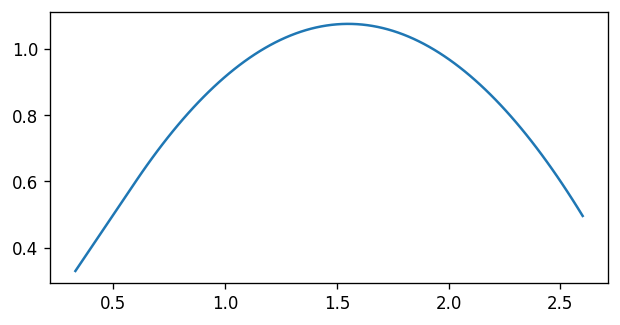

In [79]:
plt.plot(x, lq(x, -0.526, 0.6))

In [ ]:
                t